In [ ]:
!pip install torch -Uq
!pip install transformers -Uq
!pip install tiktoken -Uq
!pip install datasets -Uq
!pip install matplotlib -Uq

In [ ]:
import json
import torch
import torch.nn as nn
import plotly.graph_objects as go
import plotly.offline

In [ ]:
class Tokenizer:
  def __init__(self, vocab_path):
    with open(vocab_path, "r", encoding="utf-8") as f:
      self.vocab = json.load(f)
      self.reverse_vocab = {v: k for k, v in self.vocab.items()}

  def encode(self, text):
    tokens = []

    for word in text.split():
      i = 0
      while i < len(word):
        found_match = False
        for j in range(len(word), i, -1):
          subword = word[i:j]
          if subword in self.vocab:
            tokens.append(self.vocab[subword])
            i = j
            found_match = True
            break
        if not found_match:
          tokens.append(self.vocab.get("<unk>", 0))
          i += 1
      tokens.append(self.vocab.get(" ", 1))
    if tokens:
      tokens.pop()
    return tokens

  def tokenize(self, text):
    token_ids = self.encode(text)
    return [self.reverse_vocab[id] for id in token_ids]

  def decode(self, ids):
    text = ""
    for id in ids:
      text += self.reverse_vocab.get(id, "<unk>")
    return text

In [ ]:
def get_rotary_position_encoding(input: torch.Tensor, base=10000, device="cpu"):
  context_length, dimension = input.shape

  assert dimension % 2 == 0, "boyutlar eşit olmalıdır"

  half_dimension = dimension // 2

  freqs_indices = torch.arange(0, half_dimension, device=device, dtype=torch.float32)
  freqs = 1.0 / (base ** (freqs_indices / dimension))

  positions = torch.arange(0, context_length, device=device, dtype=torch.float32).unsqueeze(1)

  angles = positions * freqs

  sin_angles = torch.sin(angles)
  cos_angles = torch.cos(angles)

  input_even = input[:, :dimension // 2]
  input_odd = input[:, dimension // 2:]

  input_even_rotated = input_even * cos_angles - input_odd * sin_angles
  input_odd_rotated = input_even * sin_angles + input_odd * cos_angles

  input_rotated = torch.empty_like(input)

  input_rotated[:, :dimension // 2] = input_even_rotated
  input_rotated[:, dimension // 2:] = input_odd_rotated

  return input_rotated

In [ ]:
class UstaModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_length):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.get_pos = get_rotary_position_encoding

  def forward(self, x):
    x = self.embedding(x)
    x = self.get_pos(x)
    return x

In [ ]:
def plot_dots(sentences_data, title, dims=[0, 1, 2]):
  data = [
    go.Scatter3d(
      x=sentence_data["words"][:, dims[0]],
      y=sentence_data["words"][:, dims[1]],
      z=sentence_data["words"][:, dims[2]],
      mode="markers+text",
      marker=dict(
        size=6,
        color=sentence_data["color"],
      ),
      text=sentence_data["labels"],
      hoverinfo="text",
    ) for sentence_data in sentences_data
  ]

  layout = go.Layout(
    scene=dict(
      xaxis_title="Hardness",
      yaxis_title="Brightness",
      zaxis_title="Redness",
    ),
    title=title,
    width=1000,
    height=1000,
  )

  fig = go.Figure(data=data, layout=layout)
  plotly.offline.iplot(fig)

In [ ]:
tokenizer = Tokenizer("tokenizer_1.json")

In [ ]:
prompt = "the capital of united states and the capital of france"

In [ ]:
tokens = tokenizer.encode(prompt)

In [ ]:
x = torch.tensor(tokens, dtype=torch.long)

In [ ]:
torch.manual_seed(42)

In [ ]:
model = UstaModel(vocab_size=len(tokenizer.vocab), embedding_dim=4, context_length=32)

In [ ]:
model(x)

In [ ]:
sentence_meanings = model(x)

In [ ]:
sentence_meanings.shape

torch.Size([20, 4])

In [ ]:
sentences = [
  {
    "words": sentence_meanings.detach().numpy(),
    "labels": tokenizer.tokenize(prompt),
    "color": "red",
  },
]

plot_dots(sentences, "Models Context Space")

In [ ]:
sentence_meanings

In [ ]:
all_similarities = torch.zeros(sentence_meanings.shape[0], sentence_meanings.shape[0])
for j in range(sentence_meanings.shape[0]):
  j_similarities = torch.zeros(sentence_meanings.shape[0])

  for i in range(sentence_meanings.shape[0]):
    for k in range(sentence_meanings.shape[1]):
      cs_j_i = sentence_meanings[j][k] * sentence_meanings[i][k]
      j_similarities[i] += cs_j_i

  all_similarities[j] = j_similarities

In [ ]:
attention_weights = torch.softmax(all_similarities, dim=1)

In [ ]:
all_similarities.detach().numpy()

In [ ]:
'''class UstaSelfAttention(nn.Module):
  def __init__(self, embedding_dim, output_dim):
    super().__init__()
    self.embedding_dim = embedding_dim

    self.q_weights = nn.Linear(embedding_dim, output_dim, bias=False)
    self.k_weights = nn.Linear(embedding_dim, output_dim, bias=False)
    self.v_weights = nn.Linear(embedding_dim, output_dim, bias=False)

  def forward(self, x):
    q = self.q_weights(x)
    k = self.k_weights(x)
    v = self.v_weights(x)

    attention_scores = q @ k.T
    attention_weights = torch.softmax(attention_scores / k.shape[-1] ** 0.5, dim=1)
    return attention_weights @ v'''

In [ ]:
'''class UstaModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_length):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.pos_embedding = nn.Embedding(context_length, embedding_dim)
    self.get_pos = get_rotary_position_encoding
    self.self_attention = UstaSelfAttention(embedding_dim, embedding_dim)

  def forward(self, x):
    x = self.embedding(x)
    x = self.get_pos(x)
    x = self.self_attention(x)
    return x'''

##Attention atama

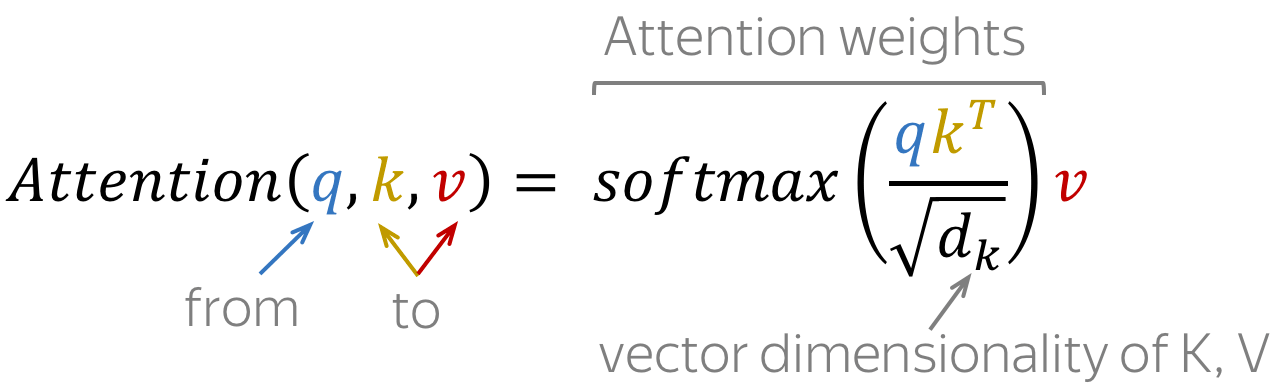

Query oluştururken cümleyi doğrudan kullanmak yerine, her kelimeyi belirli ağırlık matrisleriyle (query ağırlıkları) çarparız.


Aynı işlemi key ve value için de ayrı ağırlık matrisleriyle yaparız.

Bu sayede her kelime 3 farklı şekilde temsil edilir:

*  Query (Q): "Ben kime dikkat etmeliyim?"
*  Key (K):   "Bana dikkat edilmeli mi?"
*  Value (V): "Benim taşıdığım bilgi nedir?"

kök dk yüksek boyutun şişirdiği dot-product’ı söndürüp softmax’ı kararlı tutar yoksa öğrenme zorlaşır

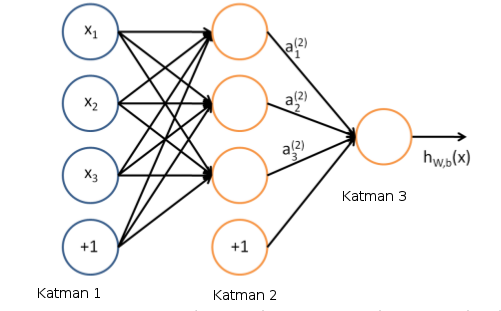

Görseldeki sinir ağı diyagramında, bu işlem bir yapay sinir ağı katmanında gerçekleşen lineer dönüşümlere benzer. (x * W)

Önceki Yaptığımız:

In [ ]:
attention_weight = sentence_meanings @ sentence_meanings.T

In [ ]:
attention_weight

Şimdi Yapacağımız:

In [ ]:
# 4 boyutlu (embedding_dim=4) vektörleri 3 boyutlu (output_dim=3) uzaylara dönüştürüyoruz.
q_weights = torch.nn.Linear(4, 3, bias=False)
k_weights = torch.nn.Linear(4, 3, bias=False)
v_weights = torch.nn.Linear(4, 3, bias=False)

In [ ]:
q_weights, k_weights, v_weights

Ağırlık matrisleri rastgele başlatılır.
Model eğitildikçe bu ağırlıklar dilin ilişkilerini öğrenir.

In [ ]:
q_weights.weight, k_weights.weight, v_weights.weight

In [ ]:
q_weights.weight.shape, k_weights.weight.shape, v_weights.weight.shape

In [ ]:
q_weights(sentence_meanings)

*   Cümlenin her kelimesi bu üç ağırlık matrisiyle çarpılır
*   Böylece her kelimenin üç farklı temsil uzayı (Q, K, V) elde edilir
*   Bu uzaylar aynı cümlenin üç farklı “görünümü” gibidir.

In [ ]:
q_of_sentence = q_weights(sentence_meanings)
k_of_sentence = k_weights(sentence_meanings)
v_of_sentence = v_weights(sentence_meanings)

q_of_sentence.shape, k_of_sentence.shape, v_of_sentence.shape

In [ ]:
sentences = [
  {
    "words": q_of_sentence.detach().numpy(),
    "labels": tokenizer.tokenize(prompt),
    "color": "purple",
  },
  {
    "words": k_of_sentence.detach().numpy(),
    "labels": tokenizer.tokenize(prompt),
    "color": "orange",
  },
  {
    "words": v_of_sentence.detach().numpy(),
    "labels": tokenizer.tokenize(prompt),
    "color": "blue",
  },
]

plot_dots(sentences, "Query, Key, Value Space")

Query ve Key matrislerinin çarpımı ile benzerlik skorları bulunur
(Q @ K^T)

Skorlar √dk (Key boyutu) ile ölçeklenir ve böylelikle softmax'ın aşırı doymasını önler

Ardından Softmax uygulanır — skorlar olasılıklara dönüştürülür

Value matrisine bu dikkat (attention) ağırlıklarıyla çarpılır ve sonucunda bilgiyle zenginleştirilmiş bağlam vektörleri elde edilir

In [ ]:
attention_scores = q_of_sentence @ k_of_sentence.T

In [ ]:
attention_weight = torch.softmax(attention_scores/(k_of_sentence.shape[-1] ** 0.5), dim=1)

In [ ]:
context_vector = attention_weight @ v_of_sentence

Artık bilgiyle zenginlemiş durumda

In [ ]:
context_vector

In [ ]:
sentences = [
  {
    "words": q_of_sentence.detach().numpy(),
    "labels": tokenizer.tokenize(prompt),
    "color": "purple",
  },
  {
    "words": k_of_sentence.detach().numpy(),
    "labels": tokenizer.tokenize(prompt),
    "color": "orange",
  },
  {
    "words": v_of_sentence.detach().numpy(),
    "labels": tokenizer.tokenize(prompt),
    "color": "blue",
  },
  {
    "words": context_vector.detach().numpy(),
    "labels": tokenizer.tokenize(prompt),
    "color": "green",
  },
]

plot_dots(sentences, "Query, Key, Value and Context Vector Space")

Şu an değerler tamamen rastgele olduğu için sonuçlar anlamsız görünebilir

Eğitim tamamlandığında Q, K, V ağırlıkları anlamlı hale gelir ve model kelimeler arası ilişkileri öğrenir.

In [ ]:
class UstaSelfAttention(nn.Module):
  def __init__(self, embedding_dim, output_dim):
    super().__init__()
    self.embedding_dim = embedding_dim

    self.q_weights = nn.Linear(embedding_dim, output_dim, bias=False)
    self.k_weights = nn.Linear(embedding_dim, output_dim, bias=False)
    self.v_weights = nn.Linear(embedding_dim, output_dim, bias=False)

  def forward(self, x):
    q = self.q_weights(x)
    k = self.k_weights(x)
    v = self.v_weights(x)

    attention_scores = q @ k.T
    attention_weights = torch.softmax(attention_scores / k.shape[-1] ** 0.5, dim=1)
    return attention_weights @ v

In [ ]:
class UstaModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_length):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.pos_embedding = nn.Embedding(context_length, embedding_dim)
    self.get_pos = get_rotary_position_encoding
    self.self_attention = UstaSelfAttention(embedding_dim, embedding_dim)

  def forward(self, x):
    x = self.embedding(x)
    x = self.get_pos(x)
    x = self.self_attention(x)
    return x

In [ ]:
tokenizer = Tokenizer("tokenizer_1.json")

prompt = "the capital of united states and the capital of france"

tokens = tokenizer.encode(prompt)

x = torch.tensor(tokens, dtype=torch.long)

torch.manual_seed(42)
model = UstaModel(vocab_size=len(tokenizer.vocab), embedding_dim=4, context_length=32)

sentence_meanings_with_attention_context = model(x)
sentence_meanings_with_attention_context, sentence_meanings_with_attention_context.shape

In [ ]:
model

##Causal(Nedensel) Self Attention

Önceki derslerde 20x20 e matrisimiz oluşuyordu ağırlıkları kullanarak o tokenin cümle içinde ne kadar önemli olduğunu görüyorduk

In [ ]:
attention_weights.shape

In [ ]:
attention_weights

Genelde bir dil modelinde amaç sonraki kelimeyi tahmin etmektir

Bu yüzden, herhangi bir token kendisinden sonra gelen token'ları görememeli

O yüzden diogonal olarak üst kısmın değerlerini 0'lamamız gerekmekte

In [ ]:
mask_try = torch.tril(torch.ones(10, 10)) #triangular lower
mask_try

In [ ]:
mask = torch.tril(torch.ones(attention_weights.shape[0], attention_weights.shape[0]))
mask

In [ ]:
masked_attention_weight = attention_weight * mask

In [ ]:
masked_attention_weight

Ama artık softmax'a uymuyor neden?

In [ ]:
torch.sum(attention_weight, dim=1)

In [ ]:
torch.sum(masked_attention_weight, dim=1)

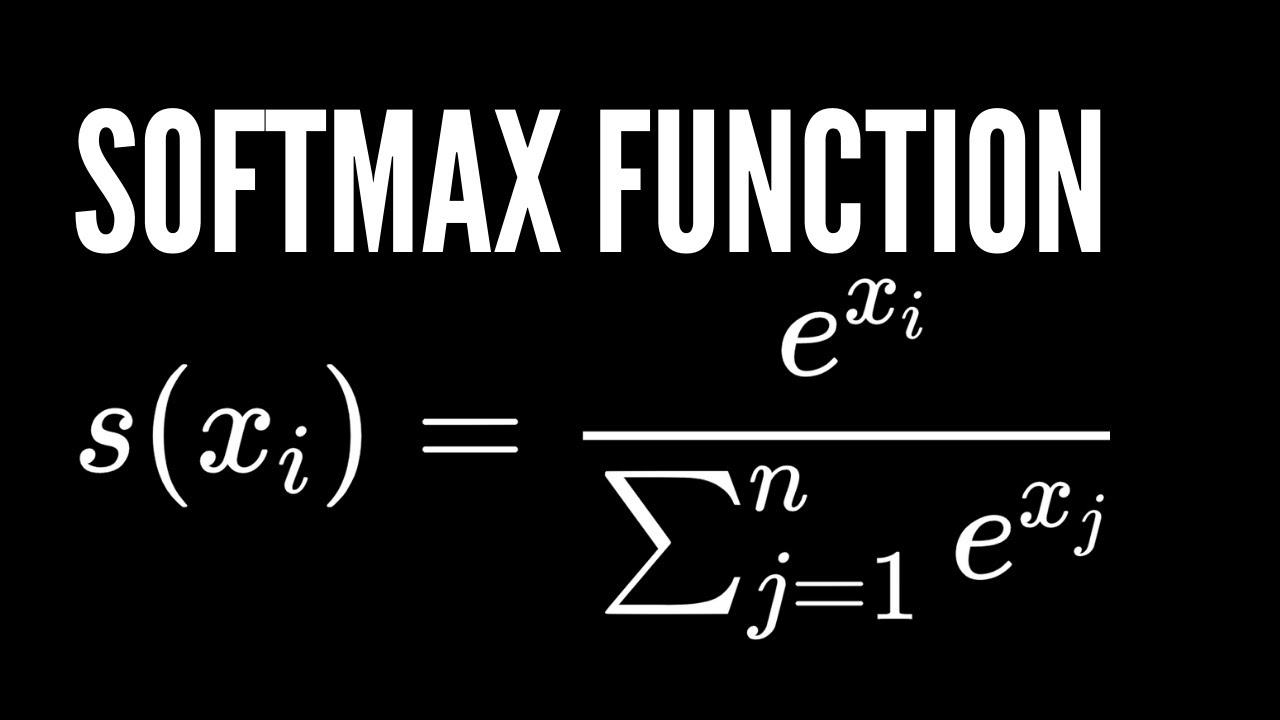

0 yerine -∞ yazdığımızda e üzeri -∞ = 0 dan bu hücrelerin olasılığı 0 olur

Kalan hücreler softmax ile toplamı 1 olacak şekilde normalie edilir

Sayılar sonsuz küçük olunca e üzeri 0dan 1 olacak ve softmax'a uyum sağlayacak

In [ ]:
masked_attention_weight = attention_weight.masked_fill(mask == 0, -torch.inf)

In [ ]:
masked_attention_weight

In [ ]:
softmaxed_attention_weights = torch.softmax(masked_attention_weight, dim=1)

In [ ]:
softmaxed_attention_weights

###Her modelde olmayan bir şey


Bazı attention ağırlıkları aşırı baskınlaşabilir

Aşırı ezberlemeyi azaltmak için rastgele bazı ağırlıkları geçici olarak kapatırız ve buna Dropout deriz

In [ ]:
dropout_rate = 0.5

In [ ]:
dropout = torch.nn.Dropout(dropout_rate)

In [ ]:
dropout

Her çalıştığımızda rastgele bir ağırlığın üstü kapatılır

In [ ]:
torch.manual_seed(42) #normal eğitim aşamasında kullanılmaz

In [ ]:
dropout(softmaxed_attention_weights)

In [ ]:
class UstaCausalAttention(nn.Module):
  def __init__(self, embedding_dim, output_dim, context_length, dropout_rate = 0):
    super().__init__()
    self.embedding_dim = embedding_dim

    # her token'ı Q, K, V uzaylarına projeliyoruz
    self.q_weights = nn.Linear(embedding_dim, output_dim, bias=False)
    self.k_weights = nn.Linear(embedding_dim, output_dim, bias=False)
    self.v_weights = nn.Linear(embedding_dim, output_dim, bias=False)

    self.dropout = nn.Dropout(dropout_rate) # Attention sonrası düzenleme için dropout

    # maskeyi modelin içinde saklıyoruz
    self.register_buffer("mask", torch.tril(torch.ones(context_length, context_length)))
    self.context_length = context_length

  def forward(self, x): # x: (T, D) — T: token sayısı, D: embedding_dim
    number_of_tokens = x.shape[0]
    x = x[:self.context_length] #Çok uzun girdilerde context_length ile kırp
    q = self.q_weights(x)
    k = self.k_weights(x)
    v = self.v_weights(x)

    attention_scores = q @ k.T #Benzerlik skorları
    attention_scores = attention_scores.masked_fill_(
      self.mask.bool()[:number_of_tokens, :number_of_tokens] == 0, -torch.inf
    ) #Causal mask
    attention_scores = torch.softmax(attention_scores / k.shape[-1] ** 0.5, dim=1) #Ölçekli softmax
    attention_scores = self.dropout(attention_scores)

    return attention_scores @ v

In [ ]:
class UstaModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_length):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.pos_embedding = nn.Embedding(context_length, embedding_dim)
    self.get_pos = get_rotary_position_encoding
    self.self_attention = UstaCausalAttention(embedding_dim, embedding_dim, context_length, dropout_rate=0.5)

  def forward(self, x):
    x = self.embedding(x)
    x = self.get_pos(x)
    x = self.self_attention(x)
    return x

##Multi Head Attention

Buradaki ana fikir aynı girdi üzerinde birden fazla head ile farklı bağlam yakalamak

Her head kendi Q-K-V'siyle
kendi attention'ını hesaplar ve çıktılar yan yana birleştirilir

In [ ]:
class UstaMultiHeadAttention(nn.Module):
  def __init__(self, embedding_dim, output_dim, context_length, num_heads, dropout_rate = 0):
    super().__init__()

    self.heads = nn.ModuleList(
      [UstaCausalAttention(embedding_dim, output_dim, context_length, dropout_rate) for _ in range(num_heads)]
    )

  def forward(self, x):
    attention_outs = []
    for head in self.heads:
      head_out = head(x)
      attention_outs.append(head_out)

    # Tüm head çıktıları "feature" ekseninde birleştirilir
    return torch.cat(attention_outs, dim=1)

In [ ]:
multi_head_attention = UstaMultiHeadAttention(4, 4, 32, 2, dropout_rate=0)

In [ ]:
out = multi_head_attention(torch.randn(4, 4))

In [ ]:
out.shape, out

In [ ]:
class UstaModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_length):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.pos_embedding = nn.Embedding(context_length, embedding_dim)
    self.get_pos = get_rotary_position_encoding
    self.self_attention = UstaMultiHeadAttention(embedding_dim, embedding_dim, context_length, num_heads = 2, dropout_rate=0.5)

  def forward(self, x):
    x = self.embedding(x)
    x = self.get_pos(x)
    x = self.self_attention(x)
    return x

In [ ]:
tokenizer = Tokenizer("tokenizer_1.json")

prompt = "the capital of united states and the capital of france"

tokens = tokenizer.encode(prompt)

x = torch.tensor(tokens, dtype=torch.long)

torch.manual_seed(42)
model = UstaModel(vocab_size=len(tokenizer.vocab), embedding_dim=4, context_length=32)

sentence_meanings_with_attention_context = model(x)
sentence_meanings_with_attention_context, sentence_meanings_with_attention_context.shape

### Daha iyi bir multi head attention

Bu sürüm PyTorch’un optimize edilmiş MHA katmanını kullanır

In [ ]:
class UstaMultiHeadAttention(nn.Module):
  def __init__(self, embedding_dim, output_dim, context_length, num_heads, dropout_rate = 0):
    super().__init__()

    self.context_length = context_length

    # giriş/çıkış başına gizli boyut, head sayısı (embed_dim % num_heads == 0), attention ağırlıkları
    self.multi_head_attention = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_rate)

    # Concat edilen başlıkların çıktısını hedef boyuta döndürmek için kullanılır
    self.projection = nn.Linear(embedding_dim, output_dim)

    self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

  def forward(self, x):
    number_of_tokens = x.shape[0]
    x = x[:self.context_length]
    attention_mask = self.mask[:number_of_tokens, :number_of_tokens]

    # bağlamsal bilgiyi toplar ve bu bilgiyi hedef boyuta ve sonraki bloğa uygun formatta dönderir
    out, _ = self.multi_head_attention(x, x, x, attn_mask=attention_mask)
    out = self.projection(out)
    return out

In [ ]:
class UstaModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, num_heads, context_length):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.pos_embedding = nn.Embedding(context_length, embedding_dim)
    self.get_pos = get_rotary_position_encoding
    self.self_attention = UstaMultiHeadAttention(embedding_dim, embedding_dim, context_length, num_heads, dropout_rate=0.5)

  def forward(self, x):
    x = self.embedding(x)
    x = self.get_pos(x)
    x = self.self_attention(x)
    return x

In [ ]:
tokenizer = Tokenizer("tokenizer_1.json")

prompt = "the capital of united states and the capital of france"

tokens = tokenizer.encode(prompt)

x = torch.tensor(tokens, dtype=torch.long)

torch.manual_seed(42)
model = UstaModel(vocab_size=len(tokenizer.vocab), embedding_dim=48, num_heads=3, context_length=32)

sentence_meanings_with_attention_context = model(x)
sentence_meanings_with_attention_context, sentence_meanings_with_attention_context.shape

In [ ]:
model